In [27]:
n_filters = [68, 68, 34, 34, 17, 17]
kernels = [(7,7,7), (7,7,7), (5,5,5), (5,5,5), (3,3,3), (3,3,3)]
n_test_subjects = 40
batch_size = 1000
n_channels = 3
patch_size = 33
middle = patch_size/2
patch_shape = (n_channels, patch_size, patch_size, patch_size)
data_patch_shape = (n_channels + 2, patch_size, patch_size, patch_size)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv3D, AveragePooling3D, MaxPooling3D, ZeroPadding3D, Dropout, Flatten, Dense, Activation
from keras.optimizers import SGD
from sklearn.feature_extraction.image import extract_patches

Using Theano backend.


In [3]:
import nibabel as nib
import SimpleITK as sitk
import glob
import numpy as np
import os
import datetime

In [4]:
from nipype.interfaces.ants import N4BiasFieldCorrection

In [5]:
import pickle
def pickle_dump(item, out_file):
    with open(out_file, "wb") as opened_file:
        pickle.dump(item, opened_file)

In [6]:
def correct_bias(in_file, out_file=None):
    n4 = N4BiasFieldCorrection()
    n4.inputs.in_file = in_file
    if not out_file:
        out_file = os.path.join(os.path.dirname(in_file), "bias_corrected_" + os.path.basename(in_file))
    n4.inputs.out_file = os.path.baspath(out_file)
    return out_file

In [7]:
def sitk_corrrect_bias(image):
    return sitk.N4BiasFieldCorrection(sitk.Cast(image, sitk.sitkFloat64),
                                      image == image)

In [8]:
def read_image(subject_folder, name):
    return sitk.ReadImage(glob.glob(os.path.join(subject_folder,
                                                 "*" + name + ".*",
                                                 "*" + name + ".*.mha"))[0])

In [9]:
def read_subject_folder(folder):    
    flair_image = sitk.ReadImage(os.path.join(folder, "Flair.nii.gz"))
    t1_image = sitk.ReadImage(os.path.join(folder, "T1.nii.gz"))
    t1c_image = sitk.ReadImage(os.path.join(folder, "T1c.nii.gz"))
    truth_image = sitk.ReadImage(os.path.join(folder, "truth.nii.gz"))
    background_image = sitk.ReadImage(os.path.join(folder, "background.nii.gz"))
    return np.array([sitk.GetArrayFromImage(t1_image), 
                     sitk.GetArrayFromImage(t1c_image), 
                     sitk.GetArrayFromImage(flair_image),
                     sitk.GetArrayFromImage(truth_image),
                     sitk.GetArrayFromImage(background_image)])

In [10]:
def delete_background_patches(batch):
    background = batch[:,4,middle,middle,middle]
    return batch[background != 1]

def train_batch(batch, model):
    print(batch.shape)
    batch = delete_background_patches(batch)
    print(batch.shape)
    x_train = batch[:,:3,:,:]
    y_train = batch[:,3,middle,middle,middle]
    del(batch)
    model.train_on_batch(x_train, y_train)

In [11]:
def index_num_2_index(index_number, array_shape):
    index = [0 for i in range(len(array_shape))]
    aaa(index_number, array_shape, -1, index)
    return index

In [12]:
def aaa(x, y, z, index):
    if x > y[z]:
        aaa(x/y[z], y, z-1, index)
    index[z] = np.remainder(x, y[z])

In [13]:
def get_n_patches(patches):
    n_patches = 1
    return product_of_array(patches.shape[:4])


def product_of_array(array):
    x = 1
    for element in array:
        x *= element
    return x

In [14]:
def pop_random(in_list):
    index = np.random.choice(range(len(in_list)))
    return in_list.pop(index)

In [15]:
def get_patch_from_index_number(index_number, patches):
    index = index_num_2_index(index_num, patches.shape[:4])
    return get_patch_from_index(index, patches)


def get_patch_from_index(index, patches):
    return patches[index[0], index[1], index[2], index[3]]

In [42]:
def iteration_is_background(index_number, patches, background_channel=4):
    index = index_num_2_index(index_number, array_shape=patches.shape[:4])
    return patches[index[0], index[1], index[2], index[3], background_channel, middle, middle, middle] == 1

def foreground_iterations(patches):
    #TODO: increase speed by removing for loop
    n_patches = get_n_patches(patches)
    iterations = []
    for i in range(n_patches):
        if not iteration_is_background(i, patches):
            iterations.append(i)
    return iterations

In [16]:
def train_model(data, model, batch_size=100):

    patches = extract_patches(data, patch_shape=data_patch_shape)
    n_patches = get_n_patches(patches)

    iterations = range(n_patches)
    while len(iterations) > 0:
        indexes_to_process = []
        if len(iterations) > batch_size:

            for i in range(batch_size):
                indexes_to_process.append(pop_random(iterations))
                
        else:
            [indexes_to_process.append(pop_random(iterations)) for i in range(len(iterations))]
        
        batch = []
        for i in indexes_to_process:
            batch.append(get_patch_from_index_number(i, patches))

        train_batch(np.array(batch), model)
        print(len(iterations))
    return model

In [16]:
subject_dirs = glob.glob("data/*/*")

In [17]:
# reomove duplicate sessions
subjects = dict()
for dirname in subject_dirs:
    subjects[dirname.split('_')[-2]] = dirname

In [18]:
subject_ids = subjects.keys()
np.random.shuffle(subject_ids)

In [19]:
training_ids = subject_ids[:n_test_subjects]
testing_ids = subject_ids[n_test_subjects:]

In [20]:
pickle_dump(training_ids, "training_ids.pkl")
pickle_dump(testing_ids, "testing_ids.pkl")

In [22]:
dim_ordering = 'th'
model = Sequential()
model.add(Conv3D(input_shape=patch_shape, 
                 dim_ordering='th',
                 nb_filter=n_filters[0],
                 kernel_dim1=kernels[0][0],
                 kernel_dim2=kernels[0][1],
                 kernel_dim3=kernels[0][2],
                 activation='relu'))
# model.add(Conv3D(input_shape=patch_shape, 
#                  dim_ordering='th',
#                  nb_filter=n_filters[1],
#                  kernel_dim1=kernels[1][0],
#                  kernel_dim2=kernels[1][1],
#                  kernel_dim3=kernels[1][2],
#                  activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(input_shape=patch_shape, 
#                  dim_ordering='th',
#                  nb_filter=n_filters[2],
#                  kernel_dim1=kernels[2][0],
#                  kernel_dim2=kernels[2][1],
#                  kernel_dim3=kernels[2][2],
#                  activation='relu'))
# model.add(Conv3D(input_shape=patch_shape, 
#                  dim_ordering='th',
#                  nb_filter=n_filters[3],
#                  kernel_dim1=kernels[3][0],
#                  kernel_dim2=kernels[3][1],
#                  kernel_dim3=kernels[3][2],
#                  activation='relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2), strides=(1,1,1)))

# model.add(Conv3D(input_shape=patch_shape, 
#                  dim_ordering='th',
#                  nb_filter=n_filters[4],
#                  kernel_dim1=kernels[4][0],
#                  kernel_dim2=kernels[4][1],
#                  kernel_dim3=kernels[4][2],
#                  activation='relu'))
# model.add(Conv3D(input_shape=patch_shape, 
#                  dim_ordering='th',
#                  nb_filter=n_filters[5],
#                  kernel_dim1=kernels[5][0],
#                  kernel_dim2=kernels[5][1],
#                  kernel_dim3=kernels[5][2],
#                  activation='relu'))
# model.add(MaxPooling3D(pool_size=(2,2,2), strides=(1,1,1)))

model.add(Flatten())
model.add(Dense(5, init='normal'))
model.add(Activation('softmax'))
sgd = SGD(lr=0.001, decay=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')

In [ ]:
for subject_dir in subject_dirs:
    train_model(read_subject_folder(subject_dir), model, batch_size=batch_size)
    date = datetime.datetime.now().date()
    time = datetime.datetime.now().time()
    model_file = "model_{0}{1}{2}_{3}:{4}:{5}.h5".format(date.year, date.month, date.day,
                                                         time.hour, time.minute, time.second)
    model.save(moel_file)

(1000, 5, 33, 33, 33)
(0, 5, 33, 33, 33)


In [17]:
data = read_subject_folder("data/HGG/brats_2013_pat0001_1/")

In [18]:
data.shape

(5, 155, 240, 240)

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

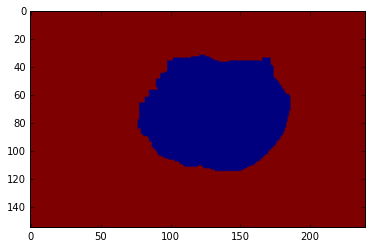

In [22]:
plt.imshow(data[4,:,:,66])

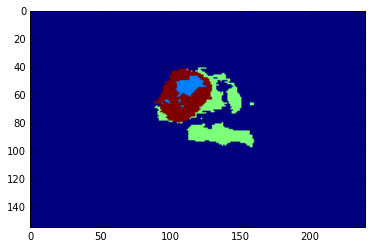

In [25]:
plt.imshow(data[3,:,:,66])

In [43]:
a = foreground_iterations(patches)

In [45]:
n_patches

5321472

In [44]:
len(a)

1474898

In [28]:
patches = extract_patches(data, patch_shape=data_patch_shape)
n_patches = get_n_patches(patches)

In [38]:
patches_final = remove_background_patches(patches)

MemoryError: 

In [30]:
background = patches[:,:,:,:,4,middle,middle,middle]

In [33]:
background.shape

(1, 123, 208, 208)

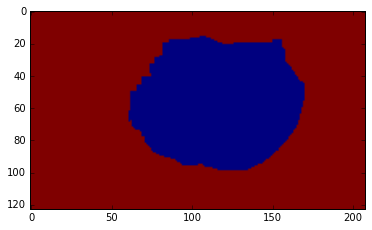

In [36]:
plt.imshow(background[0,:,:,50])